In [ ]:
! unzip /content/drive/MyDrive/datasets/clean_trainset_28spk_wav.zip
! unzip /content/drive/MyDrive/datasets/clean_testset_wav.zip
! unzip /content/drive/MyDrive/datasets/noisy_testset_wav.zip
! unzip /content/drive/MyDrive/datasets/noisy_trainset_28spk_wav.zip
! unzip /content/drive/MyDrive/datasets/logfiles.zip

Streaming output truncated to the last 5000 lines.
  inflating: noisy_trainset_28spk_wav/p268_010.wav  
  inflating: noisy_trainset_28spk_wav/p268_011.wav  
  inflating: noisy_trainset_28spk_wav/p268_012.wav  
  inflating: noisy_trainset_28spk_wav/p268_013.wav  
  inflating: noisy_trainset_28spk_wav/p268_014.wav  
  inflating: noisy_trainset_28spk_wav/p268_015.wav  
  inflating: noisy_trainset_28spk_wav/p268_016.wav  
  inflating: noisy_trainset_28spk_wav/p268_017.wav  
  inflating: noisy_trainset_28spk_wav/p268_018.wav  
  inflating: noisy_trainset_28spk_wav/p268_019.wav  
  inflating: noisy_trainset_28spk_wav/p268_020.wav  
  inflating: noisy_trainset_28spk_wav/p268_021.wav  
  inflating: noisy_trainset_28spk_wav/p268_022.wav  
  inflating: noisy_trainset_28spk_wav/p268_024.wav  
  inflating: noisy_trainset_28spk_wav/p268_025.wav  
  inflating: noisy_trainset_28spk_wav/p268_026.wav  
  inflating: noisy_trainset_28spk_wav/p268_027.wav  
  inflating: noisy_trainset_28spk_wav/p268_028.w

In [ ]:
! pip install wavinfo
! sudo apt install sox

     |████████████████████████████████| 631 kB 14.2 MB/s 
     |████████████████████████████████| 109 kB 68.6 MB/s 
     |████████████████████████████████| 6.4 MB 54.4 MB/s 
     |████████████████████████████████| 546 kB 64.8 MB/s 
  Created wheel for ear: filename=ear-2.1.0-py3-none-any.whl size=668352 sha256=8376b9c48433995404cc58128a73546f5fe064a8bbaf1444ecccc81c50a8fb8e
  Stored in directory: /root/.cache/pip/wheels/07/70/1e/67526c82388980847f2c15ea93273759428af4107715b642ac
Successfully built ear
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cud

In [ ]:
import os
import pandas as pd
import numpy as np
import subprocess
import glob
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
from keras.layers import BatchNormalization,Dropout,Dense,Input,LeakyReLU
from keras import backend as K
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras.models import Model
from keras.utils import plot_model
from keras.initializers import he_normal
from keras.models import model_from_json
from keras import optimizers

In [ ]:
trainset_28spk_text = open("/content/log_trainset_28spk.txt",'r')
trainset_text = trainset_28spk_text.readlines()
Male=['p226','p227','p243','p256','p254','p258','p259','p270','p273','p274','p278','p279','p286','p287']
Gender=[]
spkr_id = []
file_name_clean = []
file_name_noisy = []
duration_clean = []
duration_noisy = []
noise =[]
SNR=[]
sample_rate_clean = []
sample_rate_noisy = []
for i in trainset_text:
  file_name_clean.append(i.split()[0]+".wav")
  file_name_noisy.append(i.split()[0]+".wav")
  spkr_id.append(i.split()[0].split("_")[0])
  noise.append(i.split()[1])
  SNR.append(i.split()[2])
  d,fsc = sf.read("/content/clean_trainset_28spk_wav/"+i.split()[0]+".wav")
  duration_clean.append(len(d)/fsc)
  sample_rate_clean.append(fsc)
  d_n,fsn = sf.read("/content/noisy_trainset_28spk_wav/"+i.split()[0]+".wav")
  duration_noisy.append(len(d_n)/fsn)
  sample_rate_noisy.append(fsn)
  if i.split()[0].split("_")[0] in Male:
    Gender.append("Male")
  else:
    Gender.append("Female")
trainset = pd.DataFrame(list(zip(spkr_id,Gender,file_name_clean,duration_clean,sample_rate_clean,file_name_noisy,duration_noisy,sample_rate_noisy,noise,SNR)),
                        columns=["Speaker_ID","Gender","Clean_file_name","Clean_duration(in Seconds)","Sample_rate_clean(in KHz)","Noisy_file_name","Noisy_duration(in Seconds)","Sample_rate_Noisy(in KHz)","Noise","SNR(in dB)"])
trainset.to_csv("Trainset.csv",index=False)

In [ ]:
testset_28spk_text = open("/content/log_testset.txt",'r')
testset_text = testset_28spk_text.readlines()
Gender=[]
spkr_id = []
file_name = []
file_name_noisy = []
duration_clean = []
duration_noisy = []
noise =[]
SNR=[]
sample_rate_clean = []
sample_rate_noisy = []
for i in testset_text:
  file_name_clean.append(i.split()[0]+".wav")
  file_name_noisy.append(i.split()[0]+".wav")
  spkr_id.append(i.split()[0].split("_")[0])
  noise.append(i.split()[1])
  SNR.append(i.split()[2])
  d,fsc = sf.read("/content/clean_testset_wav/"+i.split()[0]+".wav")
  duration_clean.append(len(d)/fsc)
  sample_rate_clean.append(fsc)
  d_n,fsn = sf.read("/content/noisy_testset_wav/"+i.split()[0]+".wav")
  duration_noisy.append(len(d_n)/fsn)
  sample_rate_noisy.append(fsn)
  if i.split()[0].split("_")[0] =='p232':
    Gender.append("Male")
  else:
    Gender.append("Female")
testset = pd.DataFrame(list(zip(spkr_id,Gender,file_name_clean,duration_clean,sample_rate_clean,file_name_noisy,duration_noisy,sample_rate_noisy,noise,SNR)),
                        columns=["Speaker_ID","Gender","Clean_file_name","Clean_duration(in Seconds)","Sample_rate_clean(in KHz)","Noisy_file_name","Noisy_duration(in Seconds)","Sample_rate_Noisy(in KHz)","Noise","SNR(in dB)"])
testset.to_csv("Testset.csv",index=False)

In [ ]:
import shutil
spk_uniq=trainset["Speaker_ID"].unique()
for i in spk_uniq:
  file = trainset[trainset["Speaker_ID"]==i]["Clean_file_name"].iloc[0]
  shutil.copy("/content/clean_trainset_28spk_wav/"+file,"/content/Speakers/"+file)


In [ ]:
print(len(os.listdir("/content/clean_trainset_28spk_wav/")))
print(len(os.listdir("/content/noisy_trainset_28spk_wav/")))
print(len(os.listdir("/content/clean_testset_wav/")))
print(len(os.listdir("/content/noisy_testset_wav/")))

11572
11572
824
824


In [ ]:
! zip -r Speakers.zip "/content/Speakers"

  adding: content/Speakers/ (stored 0%)
  adding: content/Speakers/p268_001.wav (deflated 26%)
  adding: content/Speakers/p279_002.wav (deflated 24%)
  adding: content/Speakers/p227_001.wav (deflated 34%)
  adding: content/Speakers/p273_002.wav (deflated 19%)
  adding: content/Speakers/p243_001.wav (deflated 28%)
  adding: content/Speakers/p282_002.wav (deflated 22%)
  adding: content/Speakers/p276_002.wav (deflated 19%)
  adding: content/Speakers/p278_002.wav (deflated 21%)
  adding: content/Speakers/p267_001.wav (deflated 21%)
  adding: content/Speakers/p258_001.wav (deflated 25%)
  adding: content/Speakers/p274_002.wav (deflated 19%)
  adding: content/Speakers/p244_001.wav (deflated 20%)
  adding: content/Speakers/p259_001.wav (deflated 24%)
  adding: content/Speakers/p236_002.wav (deflated 15%)
  adding: content/Speakers/p256_001.wav (deflated 25%)
  adding: content/Speakers/p287_001.wav (deflated 24%)
  adding: content/Speakers/p226_001.wav (deflated 23%)
  adding: content/Speaker

In [ ]:
trainset = pd.read_csv("/content/drive/MyDrive/datasets/Trainset.csv")
testset = pd.read_csv("/content/drive/MyDrive/datasets/Testset.csv")

In [ ]:
trainset.head()

,Speaker_ID,Gender,Clean_file_name,Clean_duration(in Seconds),Sample_rate_clean(in KHz),Noisy_file_name,Noisy_duration(in Seconds),Sample_rate_Noisy(in KHz),Noise,SNR(in dB)
0,p236,Female,p236_002.wav,3.076979,48000,p236_002.wav,3.076979,48000,babble,15
1,p236,Female,p236_003.wav,5.947979,48000,p236_003.wav,5.947979,48000,babble,10
2,p236,Female,p236_005.wav,5.870000,48000,p236_005.wav,5.870000,48000,babble,5
3,p236,Female,p236_006.wav,4.940000,48000,p236_006.wav,4.940000,48000,babble,0
4,p236,Female,p236_007.wav,4.060000,48000,p236_007.wav,4.060000,48000,cafeteria,15


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Speaker_ID_count')

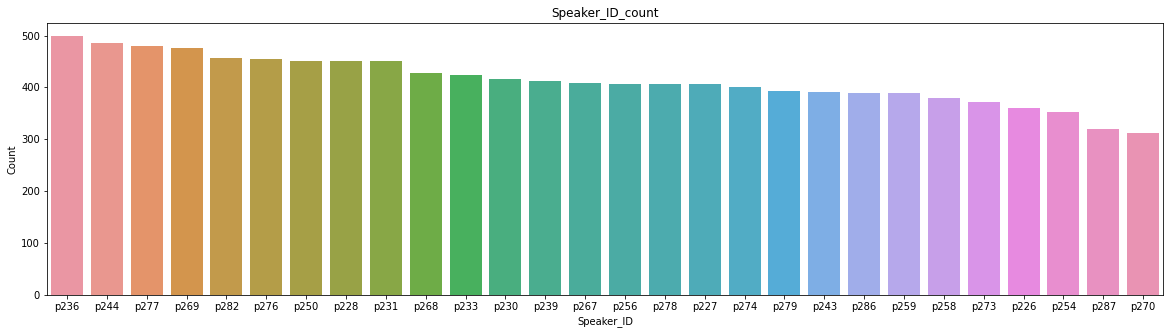

In [ ]:
plt.figure(figsize=(20,5))
x = list(trainset["Speaker_ID"].unique())
y = list(trainset["Speaker_ID"].value_counts())

sns.barplot(x,y)
plt.xlabel("Speaker_ID")
plt.ylabel("Count")
plt.title("Speaker_ID_count")

Female    5848
Male      5724
Name: Gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


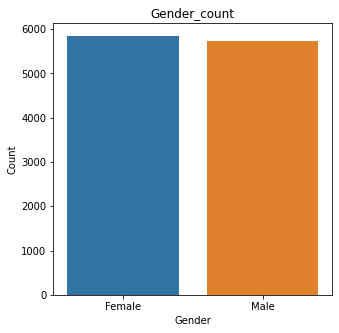

In [ ]:
plt.figure(figsize=(5,5))
x = list(trainset["Gender"].unique())
y = list(trainset["Gender"].value_counts())

sns.barplot(x,y)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender_count")
print(trainset["Gender"].value_counts())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


([<matplotlib.axis.XTick at 0x7f73dcbae610>,
 <a list of 15 Text major ticklabel objects>)

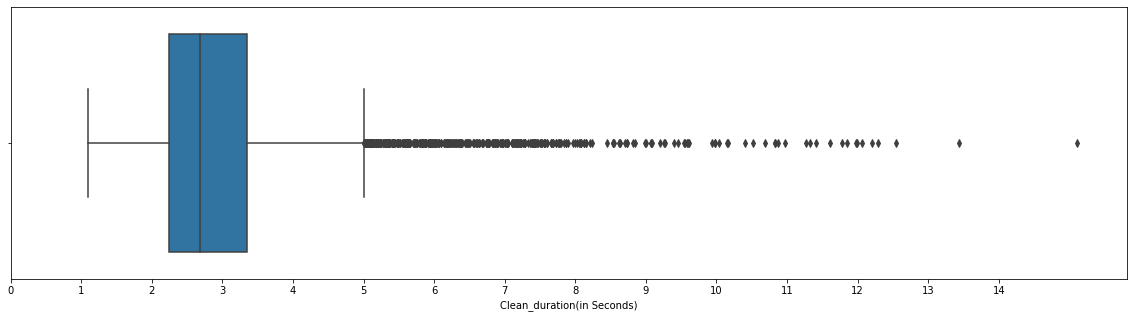

In [ ]:
plt.figure(figsize=(20,5))

sns.boxplot(trainset["Clean_duration(in Seconds)"])
plt.xticks(np.arange(0, 15, step=1))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ssn           1168
car           1159
metro         1159
babble        1158
restaurant    1157
cafeteria     1156
station       1156
meeting       1155
kitchen       1152
traffic       1152
Name: Noise, dtype: int64


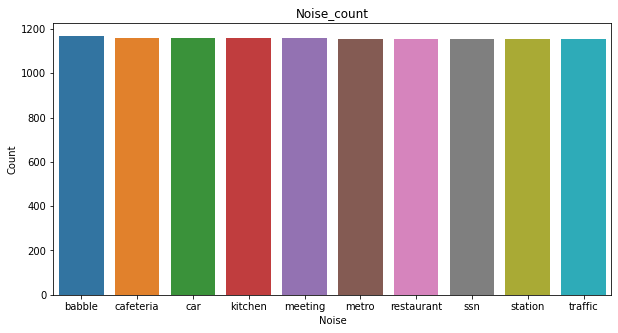

In [ ]:
plt.figure(figsize=(10,5))
x = list(trainset["Noise"].unique())
y = list(trainset["Noise"].value_counts())

sns.barplot(x,y)
plt.xlabel("Noise")
plt.ylabel("Count")
plt.title("Noise_count")
print(trainset["Noise"].value_counts())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


10    2899
15    2893
0     2893
5     2887
Name: SNR(in dB), dtype: int64


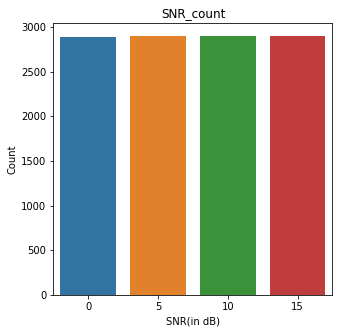

In [ ]:
plt.figure(figsize=(5,5))
x = list(trainset["SNR(in dB)"].unique())
y = list(trainset["SNR(in dB)"].value_counts())

sns.barplot(x,y)
plt.xlabel("SNR(in dB)")
plt.ylabel("Count")
plt.title("SNR_count")
print(trainset["SNR(in dB)"].value_counts())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


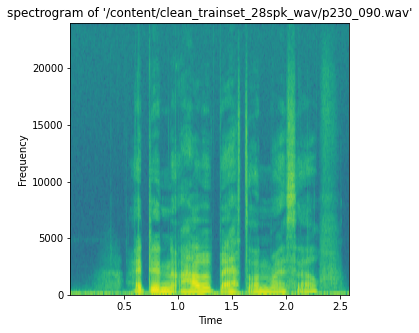

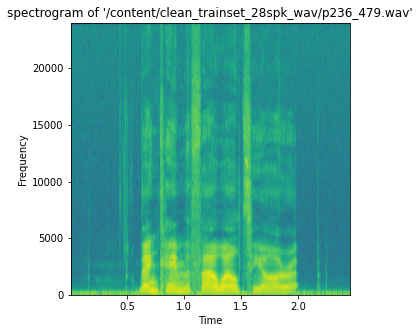

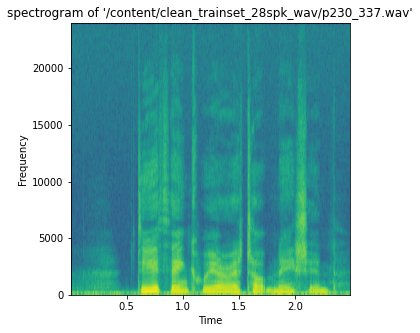

In [ ]:
import os
import wave

import pylab
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(5, 5))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.xlabel('Time')
    pylab.ylabel('Frequency')
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
for i in os.listdir("/content/clean_trainset_28spk_wav/")[0:3]:
    graph_spectrogram("/content/clean_trainset_28spk_wav/"+i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


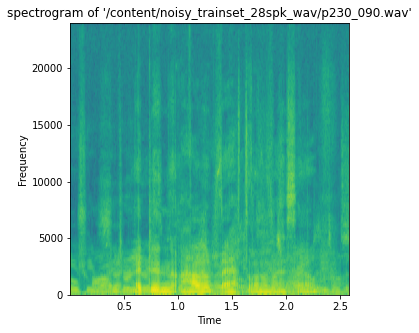

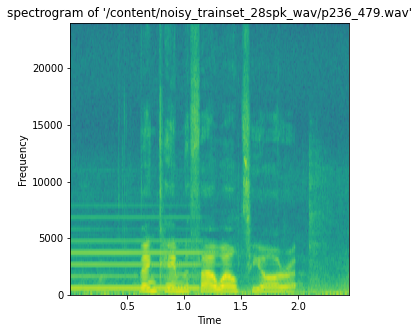

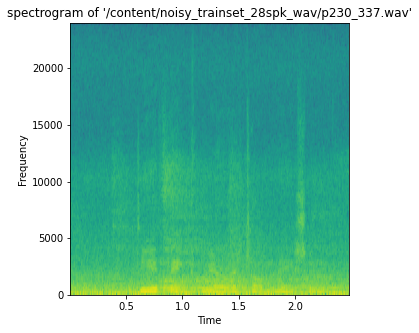

In [ ]:
for i in os.listdir("/content/noisy_trainset_28spk_wav/")[0:3]:
    graph_spectrogram("/content/noisy_trainset_28spk_wav/"+i)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
def waveform(wav_file):
  spf = wave.open(wav_file, "r")
  signal = spf.readframes(-1)
  signal = np.fromstring(signal, "Int16")
  fs = spf.getframerate()
  # If Stereo
  if spf.getnchannels() == 2:
      print("Just mono files")
      sys.exit(0)
  Time = np.linspace(0, len(signal) / fs, num=len(signal))
  plt.figure(1)
  plt.figure(num=None, figsize=(15, 5))
  plt.title(wav_file)
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.plot(Time, signal)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


<Figure size 432x288 with 0 Axes>

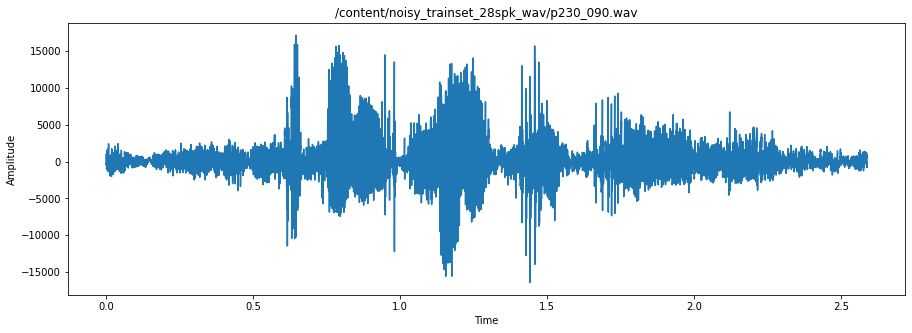

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


<Figure size 432x288 with 0 Axes>

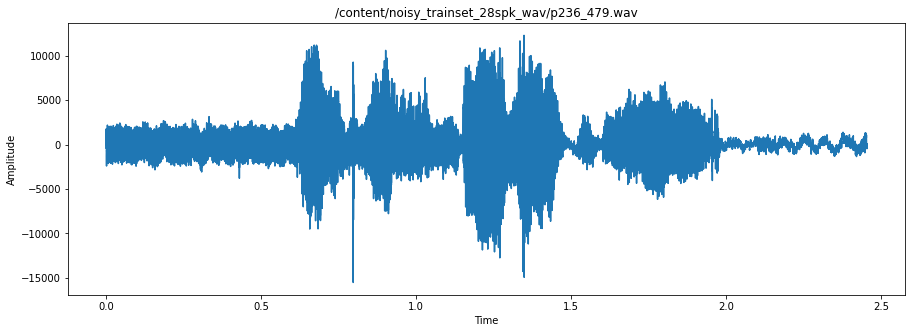

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


<Figure size 432x288 with 0 Axes>

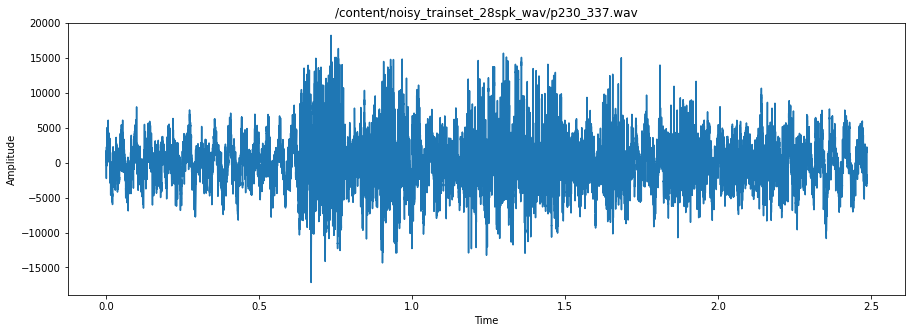

In [ ]:
for i in os.listdir("/content/noisy_trainset_28spk_wav/")[0:3]:
    waveform("/content/noisy_trainset_28spk_wav/"+i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


<Figure size 432x288 with 0 Axes>

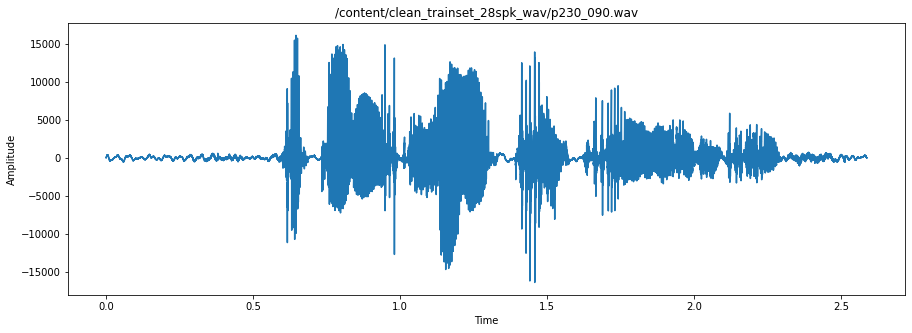

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


<Figure size 432x288 with 0 Axes>

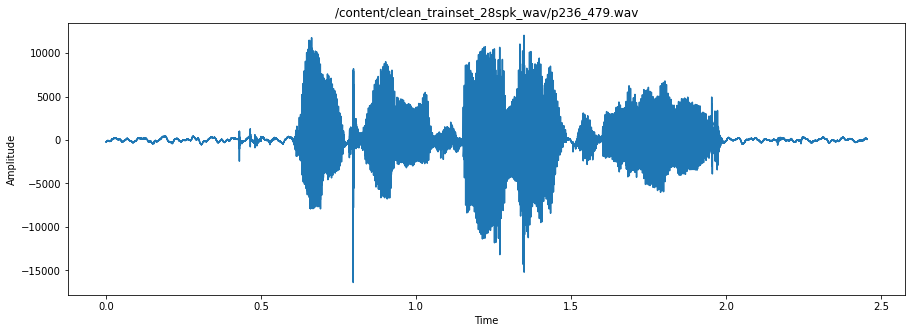

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


<Figure size 432x288 with 0 Axes>

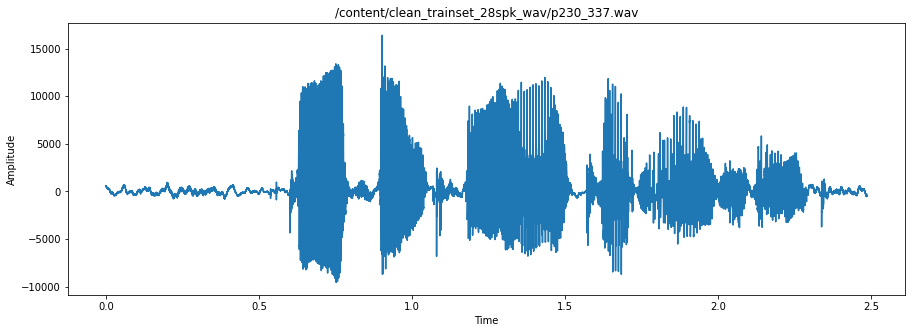

In [ ]:
for i in os.listdir("/content/clean_trainset_28spk_wav/")[0:3]:
    waveform("/content/clean_trainset_28spk_wav/"+i)

## PreProcessing

In [ ]:
fft_size = 1024
step_size = fft_size // 3 # distance to slide along the window

# fequency to mel parameter #
n_mels = 40 # number of mel frequency
start_freq = 0.0
end_freq = 8000.0

In [ ]:
import librosa

In [ ]:
def stft(data, fft_size, step_size):
    # short time fourier transform
    window = np.hamming(fft_size)
    win_num = (len(data) - 2 * fft_size) // step_size
    out = np.ndarray((win_num, fft_size), dtype=data.dtype)
    for i in range(win_num):
        left = int(i * step_size)
        right = int(left + fft_size)
        out[i] = data[left: right] * window
    F = np.fft.rfft(out, axis=1)
    return F

def istft(F, fft_size, step_size):
    # inverse short time fourier transform
    data = np.fft.irfft(F, axis=-1)
    window = np.hamming(fft_size)
    number_windows = F.shape[0]
    T = np.zeros((number_windows * step_size + fft_size))
    for i in range(number_windows):
        head = int(i * step_size)
        tail = int(head + fft_size)
        T[head:tail] = T[head:tail] + data[i, :] * window
    return T

# combine FFT bins to mel frequency bins
def mel2freq(mel_data,sr,fft_size,n_mel,fmax=8000):
    matrix= librosa.filters.mel(sr, fft_size, n_mel, fmax=fmax)
    return np.dot(mel_data,matrix)

def freq2mel(f_data,sr,fft_size,n_mel,fmax=8000):
    pre_matrix = librosa.filters.mel(sr, fft_size, n_mel, fmax=fmax)
    matrix = pre_matrix.T / np.sum(pre_matrix.T,axis=0)
    return np.dot(f_data,matrix)

# directly time to mel domain transformation
def time_to_mel(data,sr,fft_size,n_mel,step_size,fmax=8000):
    F = stft(data,fft_size,step_size)
    M = freq2mel(F,sr,fft_size,n_mel,fmax=8000)
    return M

def mel_to_time(M,sr,fft_size,n_mel,step_size,fmax=8000):
    F = mel2freq(M,sr,fft_size,n_mel)
    T = istft(F,fft_size,step_size)
    return T

def real_imag_expand(mel_data):
    # expand the complex data to 2X data with true real and image number
    D = np.zeros((mel_data.shape[0],mel_data.shape[1]*2))
    D[:,::2] = np.real(mel_data)
    D[:,1::2] = np.imag(mel_data)
    return D

# normalization function
def min_max_norm(x):
    # x should be numpy M*N matrix , normalize the N axis
    return (x-np.min(x,axis=0)) / (np.max(x,axis=0)-np.min(x,axis=0))


In [ ]:
D_X = np.empty((0,n_mels*2))
D_y = np.empty((0,n_mels*2))
for i in os.listdir("/content/clean_trainset_28spk_wav/"):
    clean_data, clean_sr = librosa.load('/content/clean_trainset_28spk_wav/'+i, sr=16000)  # time series data,sample rate
    mel_clean_data = time_to_mel(clean_data,clean_sr,fft_size,n_mels,step_size,fmax=8000)
    a = real_imag_expand(mel_clean_data)
    D_y=np.vstack((D_y,a))
    print(D_y.shape)
for i in os.listdir("/content/noisy_trainset_28spk_wav/"):
    mix_data, mix_sr = librosa.load('/content/noisy_trainset_28spk_wav/'+i, sr=16000)  # time series data,sample rate
    mel_mix_data = time_to_mel(mix_data,mix_sr,fft_size,n_mels,step_size)
    b = real_imag_expand(mel_mix_data)
    D_X=np.vstack((D_X,b))
# separate data to train test sets
D_X_train = min_max_norm(D_X[:int(D_X.shape[0]*0.9),:])
D_y_train = D_y[:int(D_y.shape[0]*0.9),:] / D_X[:int(D_X.shape[0]*0.9),:]
G_max = np.max(D_y_train)
D_y_train = D_y_train/G_max

X_test = min_max_norm(D_X[int(D_X.shape[0]*0.9):,:])
y_test = D_y[int(D_y.shape[0]*0.9):,:] / D_X[int(D_X.shape[0]*0.9):,:]
y_test = y_test/G_max

X_train, X_val, y_train, y_val = train_test_split(D_X_train, D_y_train, test_size=0.15, random_state=87)

Streaming output truncated to the last 5000 lines.
(270913, 80)
(271027, 80)
(271180, 80)
(271269, 80)
(271373, 80)
(271477, 80)
(271574, 80)
(271758, 80)
(271846, 80)
(271961, 80)
(272087, 80)
(272196, 80)
(272332, 80)
(272450, 80)
(272539, 80)
(272675, 80)
(272772, 80)
(272881, 80)
(273018, 80)
(273113, 80)
(273375, 80)
(273458, 80)
(273651, 80)
(273813, 80)
(273943, 80)
(274006, 80)
(274154, 80)
(274235, 80)
(274402, 80)
(274495, 80)
(274785, 80)
(274859, 80)
(274962, 80)
(275073, 80)
(275185, 80)
(275304, 80)
(275405, 80)
(275476, 80)
(275644, 80)
(275808, 80)
(275907, 80)
(276014, 80)
(276120, 80)
(276208, 80)
(276311, 80)
(276408, 80)
(276500, 80)
(276611, 80)
(276783, 80)
(276895, 80)
(277019, 80)
(277257, 80)
(277431, 80)
(277551, 80)
(277662, 80)
(277774, 80)
(277935, 80)
(278040, 80)
(278151, 80)
(278284, 80)
(278461, 80)
(278606, 80)
(278763, 80)
(278853, 80)
(278956, 80)
(279091, 80)
(279213, 80)
(279355, 80)
(279487, 80)
(279601, 80)
(279707, 80)
(279806, 80)
(280168, 80)


KeyboardInterrupt: ignored

In [ ]:
n_input_dim = X_train.shape[1]
n_output_dim = y_train.shape[1]

n_hidden1 = 2049
n_hidden2 = 500
n_hidden3 = 180

InputLayer1 = Input(shape=(n_input_dim,), name="InputLayer")
InputLayer2 = BatchNormalization(axis=1, momentum=0.6)(InputLayer1)

HiddenLayer1_1 = Dense(n_hidden1, name="H1", activation='relu', kernel_initializer=he_normal(seed=27))(InputLayer2)
HiddenLayer1_2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer1_1)
HiddenLayer1_3 = Dropout(0.1)(HiddenLayer1_2)

HiddenLayer2_1 = Dense(n_hidden2, name="H2", activation='relu', kernel_initializer=he_normal(seed=42))(HiddenLayer1_3)
HiddenLayer2_2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer2_1)

HiddenLayer3_1 = Dense(n_hidden3, name="H3", activation='relu', kernel_initializer=he_normal(seed=65))(HiddenLayer2_2)
HiddenLayer3_2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer3_1)

HiddenLayer2__1 = Dense(n_hidden2, name="H2_R", activation='relu', kernel_initializer=he_normal(seed=42))(HiddenLayer3_2)
HiddenLayer2__2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer2__1)

HiddenLayer1__1 = Dense(n_hidden1, name="H1_R", activation='relu', kernel_initializer=he_normal(seed=27))(HiddenLayer2__2)
HiddenLayer1__2 = BatchNormalization(axis=1, momentum=0.6)(HiddenLayer1__1)
HiddenLayer1__3 = Dropout(0.1)(HiddenLayer1__2)

OutputLayer = Dense(n_output_dim, name="OutputLayer", kernel_initializer=he_normal(seed=62))(HiddenLayer1__3)

model = Model(inputs=[InputLayer1], outputs=[OutputLayer])
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0001, amsgrad=False)
    # loss = p_loss(OutputLayer,K.placeholder())
model.compile(loss='mse', optimizer=opt)

(282, 80)

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
model.summary()
    # fit the model
hist = model.fit(X_train, y_train, batch_size=512, epochs=100, verbose=1, validation_data=([X_val], [y_val]))

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Val_Loss')
plt.legend(loc='best')
plt.title('Training Loss and Validation Loss')
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=len(y_test))
print('Test loss:%3f' % results)

In [ ]:
model.save("model.h5")
print("Saved model to disk")

In [ ]:
import keras
import scipy.io.wavfile as wavfile
def denoise(input_path,model_path,output_path):
    denoise_model=keras.models.load_model(model_path)

    mix_data, mix_sr = librosa.load(input_path, sr=16000)
    mel_mix_data = time_to_mel(mix_data,mix_sr,fft_size,n_mels,step_size)
    D_X = real_imag_expand(mel_mix_data)

    gain = denoise_model.predict(D_X) * G_max
    M_gain = gain[:,::2]+1j*gain[:,1::2]
    F_gain = mel2freq(M_gain,mix_sr,fft_size,n_mels)

    F = F_gain * stft(mix_data,fft_size,step_size)
    #ratio[np.isnan(ratio)] = 0.0
    print("shape of F_out:",F.shape)
    T = istft(F,fft_size,step_size)

    # write the result
    Tint = T/np.max(T)*32767
    wavfile.write(output_path,mix_sr,Tint.astype('int16'))